# Measurement Data and Foresight - Week 12 Practical
In this series of practicals, you'll learn how to analyse time series data using data science methodology starting from problem formulation through to storytelling with data.

<b>Week 12 Objectives</b>
At the end of this practical, you will be able to:

- Apply the seasonal-trend-residual (STR) decomposition to timeseries data
- Choose and fit an ARIMA model of the trend component of the decomposition
- Generate forecasts using the ARIMA model, and
- Evaluate the the quality of your predictions.

Indeed these comprise the steps for a model-based forecasting workflow built on the seasonal-trend-residual decomposition:
1. Isolate seasonality and trends in the data, then 
2. Model seasonal effects using straightforward averaging methods, 
3. Model trends using standard timeseries (ARIMA) models,
4. Separately forecast the seasonal and trend components, and combine them to generate forecasts for the time series.

<b>Table of Contents</b>

1. STR decomposition
2. Modeling trend with ARIMA
3. Forecasting with ARIMA 
4. Evaluating prediction

# 1. STR - Seasonal-Trend-Residual decomoposition

Last week, we explored the variety of patterns or features that time series data can display. This week, we will use trend, seasonality and cycles patterns as the basis of a <i>decomposition</i>, in which a timeseries is split into several components that are modelled separately. This first part of the practical covers the decomposition process, while later parrts cover fitting and forcasting with ARIMA models. 

Specifically, we will decompose a time series into three components:
1. we combine the trend and cycle into a single trend-cycle component (often just called the "trend" for simplicity), 
2. a seasonal component (noting that, for some time series, there can be more than one seasonal component, corresponding to the different seasonal periods), and 
3. a residual or remainder component (containing anything else in the time series). 
The result is an STR - <i>Seasonal-Trend-Residual</i> - decomoposition, sometimes called the <i>classical</i> decomposition. Athough there are more sophesiticated decompositions available, the STR decomposition is straightforward to implement and easy to interpret, making it a great starting point for thinking about forecating timeseries. 

The decomposition is achieved using the following steps:
1. Isolate the trend-cycle component
2. Calculate the de-trended series
3. Estimate the seasonal component
4. Calculate the residual component
Then we estimate a model of the trend, and combine this with the estimate of seasonality to make predictions. 

To begin, get the data into a pandas dataframe, then we will move through the decomposition steps. We continue working with the building energy data and weather data from last week. 

Prepare the workspace and read in the combined data from a saved .csv file.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

#load the data, using the "Datetime" column as the index 
filename = "data/building1-weather.csv"
df = pd.read_csv(filename,index_col="Datetime")

# Display first five rows of the data
df.head(5)

,energy_demand,temperature (degC)
Datetime,,
2019-01-10 10:15:00+11:00,8.1,17.44
2019-01-10 10:30:00+11:00,15.7,18.90
2019-01-10 10:45:00+11:00,22.8,18.90
2019-01-10 11:00:00+11:00,32.7,18.90
2019-01-10 11:15:00+11:00,8.1,18.90


Note that when reading a csv file, Pandas does not automatically recognise a column of datetimes as the index. We have told it which column is the index using the index_col optional argument. 

For ease, cast the index as a datetime type

In [2]:
# cast Datetime index datatype as 'datatime64[ns]'
df.index = df.index.astype('datetime64[ns]')

<b>Resampling:</b> Note that the temperature data repeats the same value 4 times. this is becuase it was only ever at hourly resolution, but when the dataframes were merged in last week's prac, the values were filled with repeated observation values. Resampling lets us recover the original hourly data. For ease of analysis, put the resampled data into a separate dataframe called 'df_temp'.

In [3]:
# Construct new df
df_temp = pd.DataFrame(df['temperature (degC)'])

# rename the temperature column
df_temp.rename(columns = {'temperature (degC)':'temperature'}, inplace = True)

# have to re-cast the index as a datetime object
df_temp.index = df_temp.index.astype('datetime64[ns]')

# Resample temperature to hourly observations
df_temp = df_temp.resample('1H').mean()
df_temp.head(6)

,temperature
Datetime,
2019-01-09 23:00:00,18.413333
2019-01-10 00:00:00,19.165000
2019-01-10 01:00:00,19.815000
2019-01-10 02:00:00,20.580000
2019-01-10 03:00:00,21.015000
2019-01-10 04:00:00,21.265000


A few quick plots of the data reveals some patterns of interest

<AxesSubplot:xlabel='Datetime'>

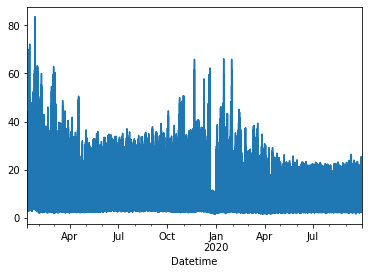

In [4]:
df['energy_demand'].plot()

<AxesSubplot:xlabel='Datetime'>

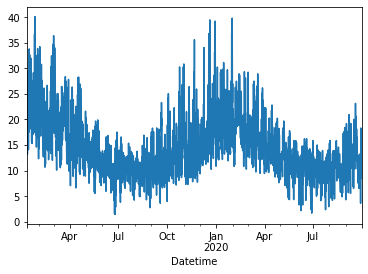

In [5]:
df_temp['temperature'].plot()

And looking closer...

<AxesSubplot:xlabel='Datetime'>

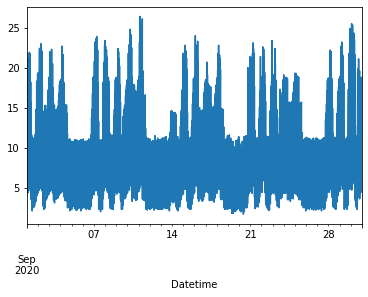

In [5]:
df['2020-09-01':'2020-10-01']['energy_demand'].plot()

<AxesSubplot:xlabel='Datetime'>

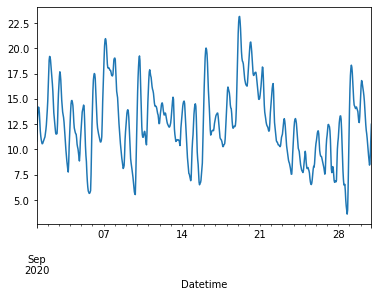

In [6]:
df_temp['2020-09-01':'2020-10-01']['temperature'].plot()

### Jumping ahead - automatic decomposition of <i>temperature</i> 

We are going to jump ahead here and use a tool from the <b>statsmodels</b> package (you may need to add it to your python environment) to look at an automatic decomposition of the <i>temperature</i> data.  It splits the timeseries and shows us the three components: trend-cycle, seasonal and residual. Note that trend and cycles are combined for this. We also need to specify the period, which is the number of observations the seasonality component has. 

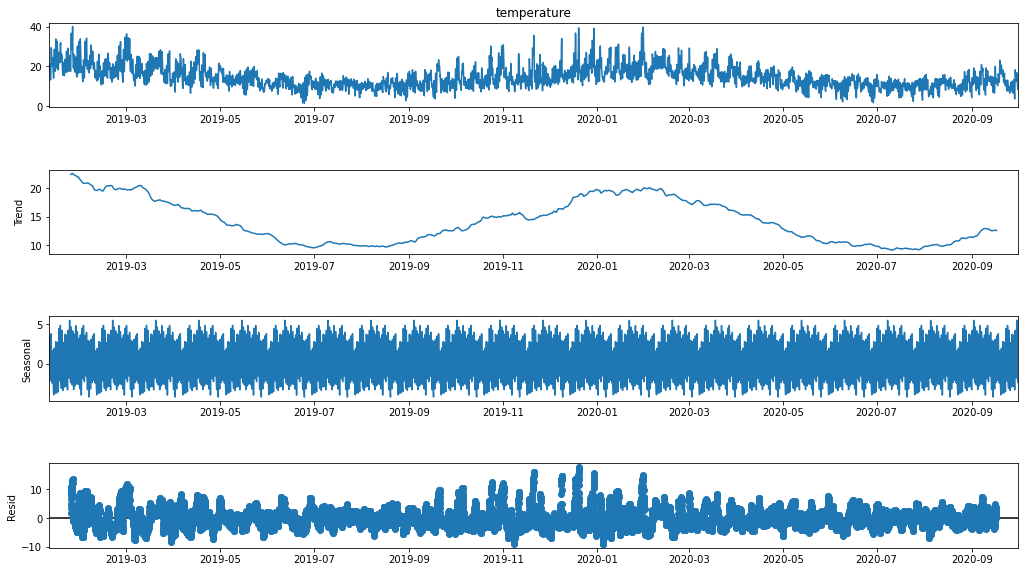

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

str_res = seasonal_decompose(df_temp['temperature'],period = (7*24*4))
fig = str_res.plot()
fig.set_size_inches((16, 9))

The goal for Section 1 of the practical is to reproduce the decomposition above, by working through the four decomposition steps.

## 1.1 Isolate the trend

Since we have a daily cycle, we can roll to 1 days and 2 days and look at the plot. 

<AxesSubplot:xlabel='Datetime'>

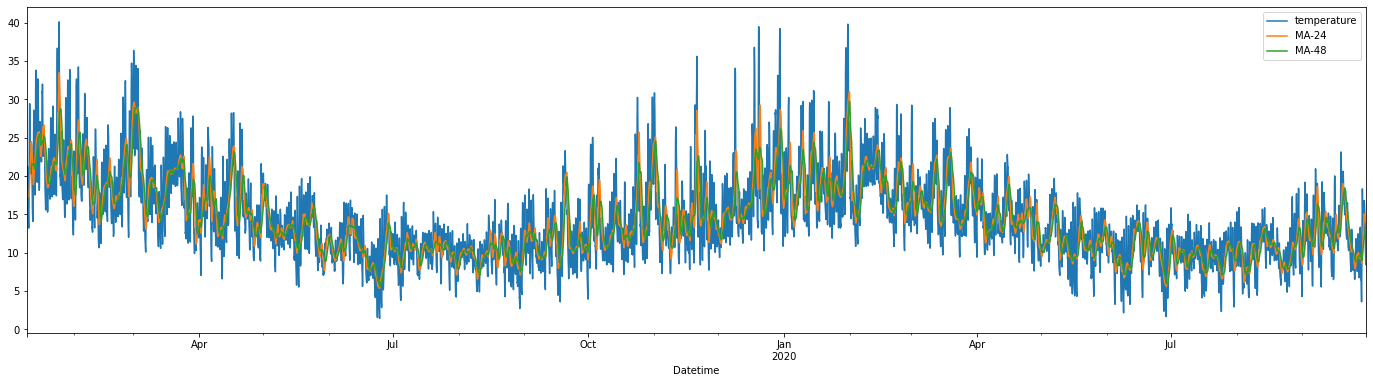

In [8]:
# We have 4 observation for an hour, so roll to 24 for one day and 24*2=48 for 2 days.
df_temp['MA-24'] = df_temp['temperature'].rolling(24).mean()
df_temp['MA-48'] = df_temp['temperature'].rolling(48).mean()
df_temp[['temperature','MA-24','MA-48']].plot(figsize=(24,6))

This does smooth the data, with regular daily "seasonal" patterns around the MA plots. Zooming in shows them clearly, but it's not completely clear which MA is the best for this data. Go with the MA-24.

<AxesSubplot:xlabel='Datetime'>

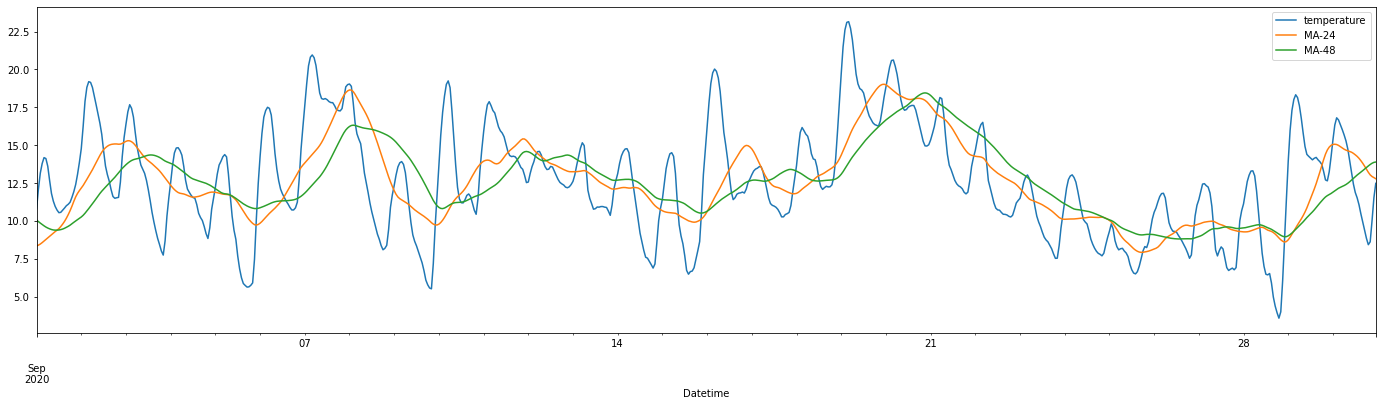

In [9]:
df_temp['2020-09-01':'2020-10-01'][['temperature','MA-24','MA-48']].plot(figsize=(24,6))

The MA-24 plot itself shows a pattern, but it is not seasonality. The pattern visible a dependence of the current value of the timeseries on previous values. E.g. a high temperature day tends to be followed by a second day of high temperatures, and vice versa. This is an example of <i>autocorrelation</i>. 

We also see that big changes in the time series tend to persist, e.g. a rapid switch from a cooler day to a warmer one tends to have a lasting impact. The is an example of <i>dependence on past errors</i>. 

Dependence on past values and past errors are captured with ARIMA models. Later in the prac, you will use an ARIMA model to forecast the trend component of the STR decomposition.

Isolate the trend component for 'energy_demand' using the same MA processes. Think about the period of the data and your expected seasonality lengths. You will see different features in the resulting MA plots.

|<center>Exercise</center>|
| ---- |
|<center> 2. What is the period of seasonality for 1 day, or 2 days? </center> |
|<center> 2. What are the patterns you see these plots? </center> |
|<center> 3. What can you do about these patterns in the MA plots of 'energy_data'? </center> |

## 1.2 Calculate the de-trended series

The next step is to calculate the de-trended temperature series. This is straightfroward: subtract the MA trend from the original temperature data.

<AxesSubplot:xlabel='Datetime'>

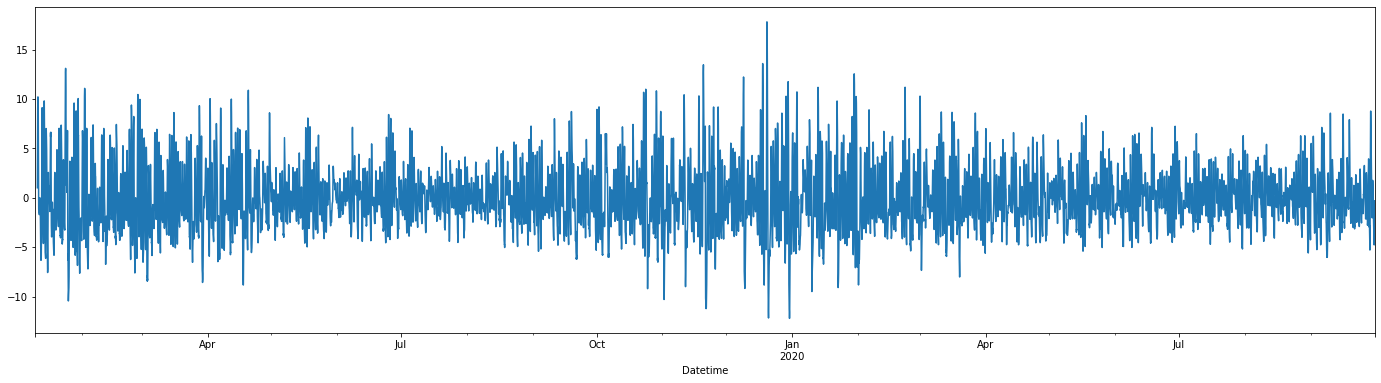

In [10]:
df_temp['temp-detrended'] = df_temp['temperature'] - df_temp['MA-24']
df_temp['temp-detrended'].plot(figsize=(24,6))

## 1.3 Estimate the seasonal component

the next step is to estimate the seasonal component. There are a rage of ways to do this, with varying degrees of sophistication. However, we will use the most straightforward, which is to estimate the mean each hour of the day. To do this, use the 'groupby' method from pandas.

<AxesSubplot:xlabel='Datetime'>

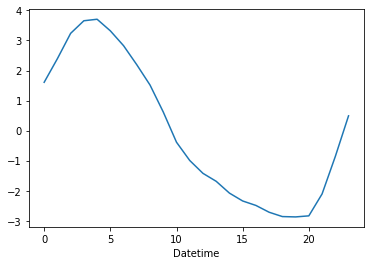

In [11]:
raw_hourly_means = df_temp.groupby(df_temp.index.hour)['temp-detrended'].mean()
raw_hourly_means.plot()

This is very close, but the seasonal components need to sum to zero or a bias will be introduced into the model. This adjustment is easy to implement: 

<AxesSubplot:xlabel='Datetime'>

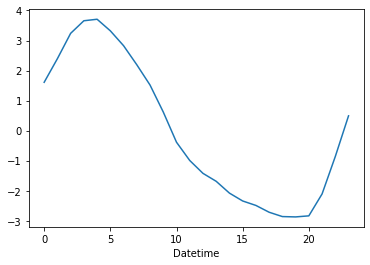

In [12]:
# Shift values so that seasonal components sum to zero
adjustment = raw_hourly_means.sum()/24.0 
hourly_means = raw_hourly_means - adjustment
hourly_means.plot()

This is exactly as we want. 

Now we have to fill the series for the entire duration of the timeseries. To do this, use numpy's tile() method. Two trick are involved: 
1. Get the lenth of the seasonal data input equal to the length of df_temp
2. Start the seasonal data at the correct time step

<AxesSubplot:xlabel='Datetime'>

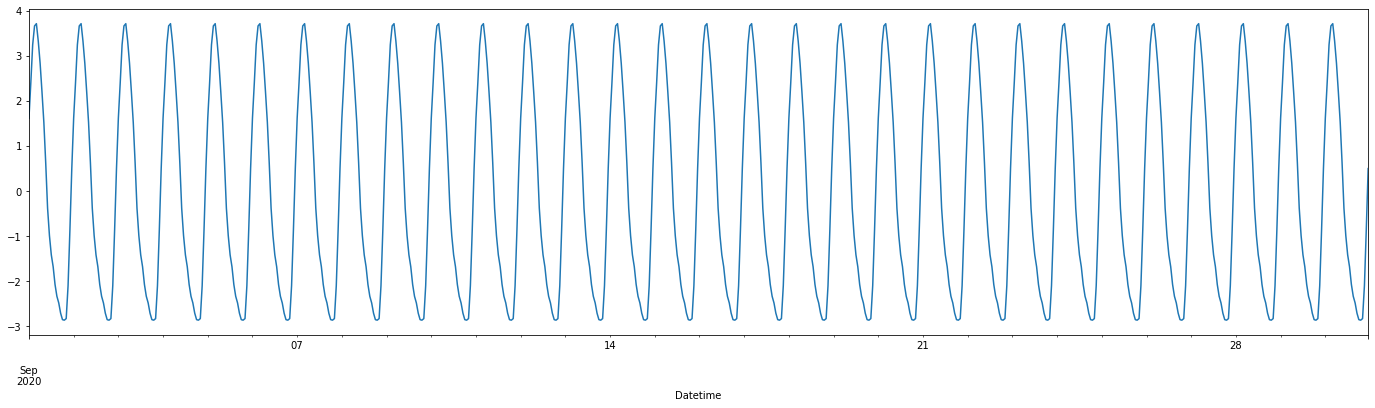

In [13]:
import numpy as np
# tile the values into the dataframe so that the entire series is filled
seasonal = np.tile(hourly_means,int(np.floor(len(df_temp)/24)))
# used typeout to check lengths:
# len(seasonal), len(df_temp)
# These are not the same so go back to check start time of series - 11PM!! - which explains the extra observation. 
# Prepending one observation
seasonal = np.insert(seasonal,0,hourly_means[23])
df_temp['temp-seasonal'] = seasonal
df_temp['2020-09-01':'2020-10-01']['temp-seasonal'].plot(figsize=(24,6))

## 1.4 Calculate the residual component 
The last step is to calulate the residual, by subtracting the seasonal component from the detrended data.

<AxesSubplot:xlabel='Datetime'>

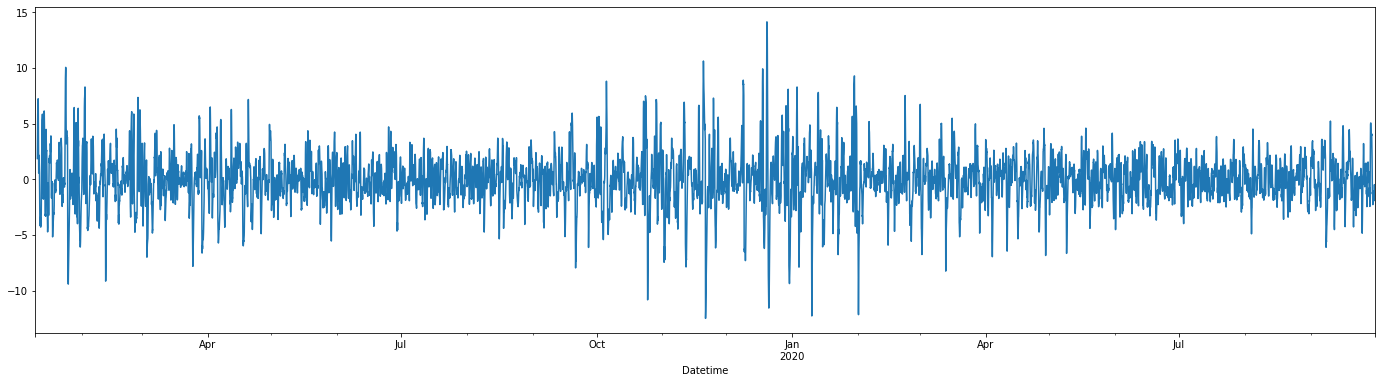

In [14]:
df_temp['temp-residual'] = df_temp['temp-detrended'] - df_temp['temp-seasonal']
df_temp['temp-residual'].plot(figsize=(24,6))

Putting the four plots on one figure:

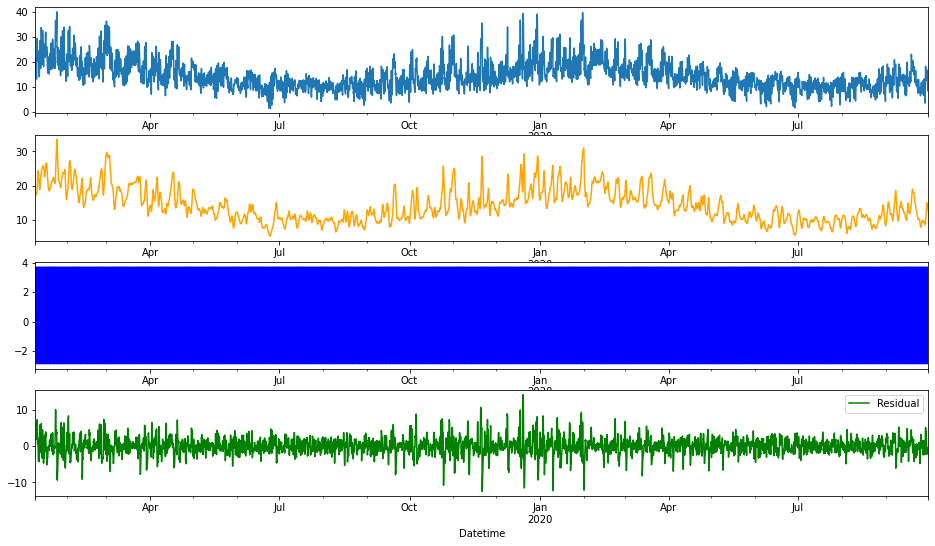

In [15]:
import matplotlib.pyplot as plt
fig, ax_str = plt.subplots(4)
df_temp['temperature'].plot(label='Original', ax=ax_str[0])
df_temp['MA-24'].plot(color='orange', label='MA-24 Trend', ax=ax_str[1])
df_temp['temp-seasonal'].plot(color='blue', label='Seasonal', ax=ax_str[2])
df_temp['temp-residual'].plot(color='green', label= 'Residual', ax=ax_str[3])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

Looking closer at two days:

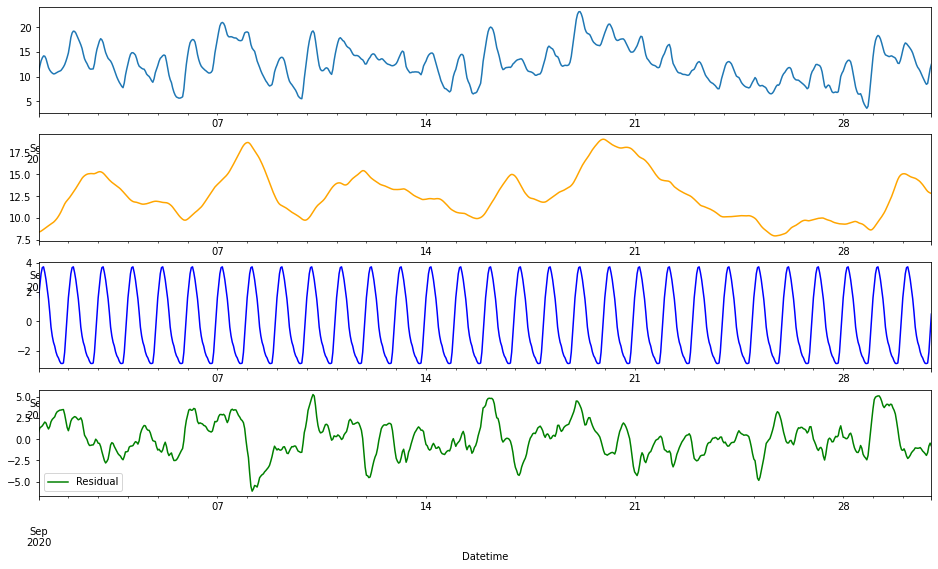

In [16]:
fig, ax_str_2 = plt.subplots(4)
df_temp['temperature']['2020-09-01':'2020-10-01'].plot(label='Original', ax=ax_str_2[0])
df_temp['MA-24']['2020-09-01':'2020-10-01'].plot(color='orange', label='MA-24 Trend', ax=ax_str_2[1])
df_temp['temp-seasonal']['2020-09-01':'2020-10-01'].plot(color='blue', label='Seasonal', ax=ax_str_2[2])
df_temp['temp-residual']['2020-09-01':'2020-10-01'].plot(color='green', label= 'Residual', ax=ax_str_2[3])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

Now that you have completed the decomposition, next you will estimate the tend component using an ARIMA model

# 2. Modelling trends with ARIMA
ARIMA -- AutoRegressive Integrated Moving Averages  -- models are a standard tool for modeling and forecasting (de-seasonalised) time series data.

Some theory of ARIMA models can be found in the course videos and in the FPP textbook. This section of the practical shows how to use the StatsModels software package to fit an ARIMA model, including how to chose the paramters:
- <i>p</i>: the AR (autoregressive) lag order
- <i>d</i>: the integration degree (or number of differences), and 
- <i>q</i>: the MA (moving averages) window length.

This involves the following four steps:

1. Check data for stationarity
 - Difference if required
 - Record the number of differences d
2. Fit a lower order model (e.g. p=1, q=1, with d as above)
3. Fit higher order models (typically increasing the AR lag parameter <i>p</i> first)
4. Compare the "goodness of fit" of the models, using the AIC and BIC,
 - If the goodness of fit metrics improve for the higher-order model, fit an even higher order model.
 - If they don’t improve by much, use the second last model you fit.
 - E.g. if moving from an ARIMA(2,1,1) model to an ARIMA(3,1,1) model shows little improvement in goodness of fit, use the ARIMA(2,1,1) model.
 - Now also try increasing the MA lag parameter

## 2.1 Check for stationarity

To fig an autoregressive model or an ARIMA model that contains an AR component, the data must be stationary. The criteria for stationarity is that the data is:
- roughly horizontal
- constant variance
- no patterns predictable in the long-term

We want to modelthe trend of the termperature data with an ARIMA model, so we have to first check that it is stationary by looking at its plot.

<AxesSubplot:xlabel='Datetime'>

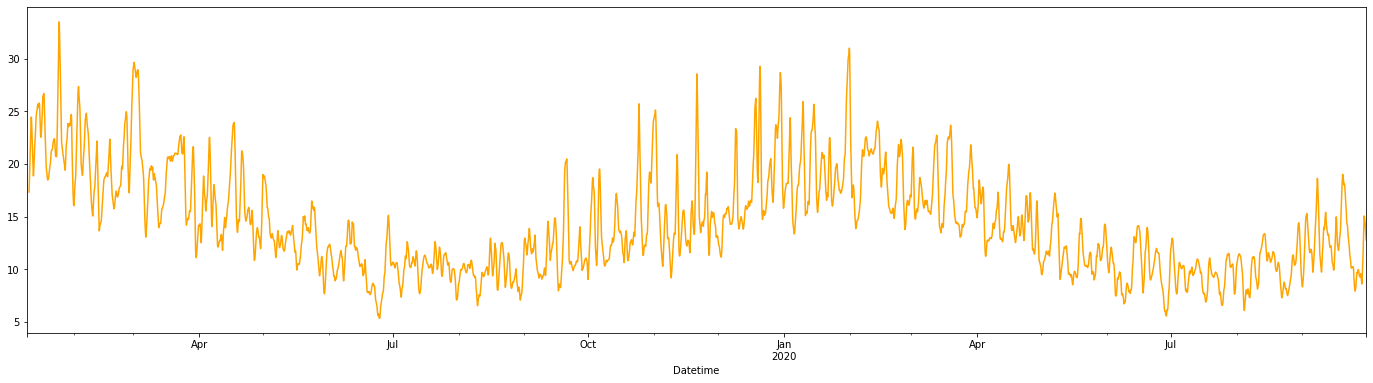

In [17]:
df_temp['MA-24'].plot(color='orange', figsize=(24,6))

Stationary? I think not. 

To attempt to make the data stationary, we can difference it.

<AxesSubplot:xlabel='Datetime'>

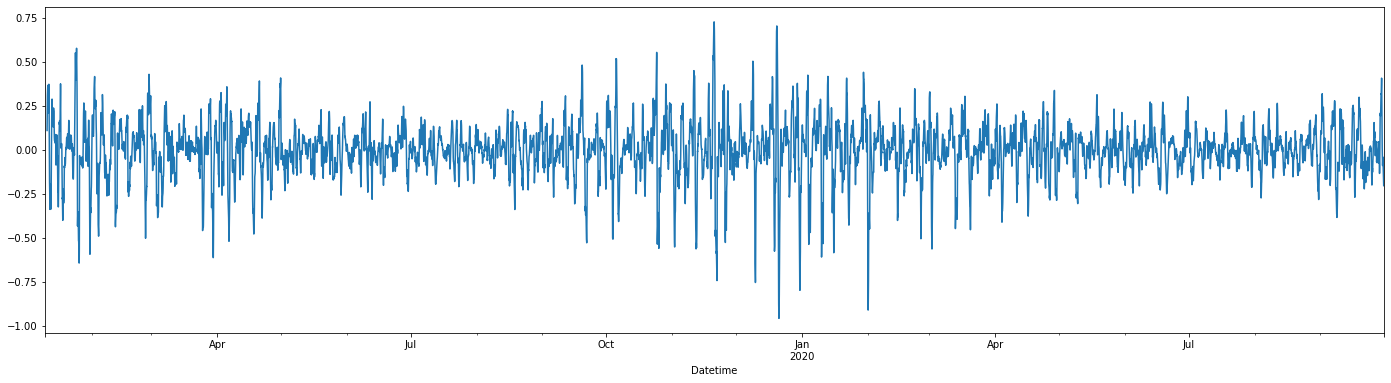

In [18]:
trend_d1 = df_temp['MA-24'].diff()
trend_d1.plot(figsize=(24,6))

This still contains lots of sub-series where the mean value moves up and down, and the variance (variability) is not constant throughout, so difference it again.

<AxesSubplot:xlabel='Datetime'>

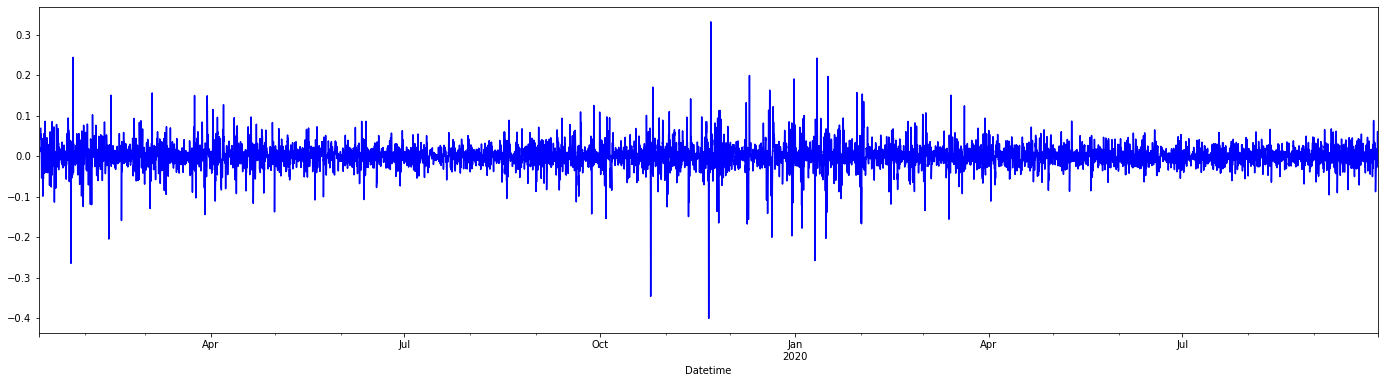

In [19]:
trend_d2 = trend_d1.diff()
trend_d2.plot(figsize=(24,6),color='blue',)

This is much better. It is not perfect, but it is good enough for us to apply an ARIMA model to. 

<b>Keep note of <i>d</i> = 2.</b>

## 2.2 Fit a lower order model

Next we use the ARIMA fitting and analysis tools from StatsModels. 

In [22]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

### 2.2.1 Evidence of autocorrelation? 
Check if there is any evidence of autocorrelation in the data using the ACF and PCF plots (autocorrelation and partial autocorrelation).

In [23]:
# trim the nan's from the differenced trend 
trend_d2 = trend_d2[26:]

C:\Users\uqachap1\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


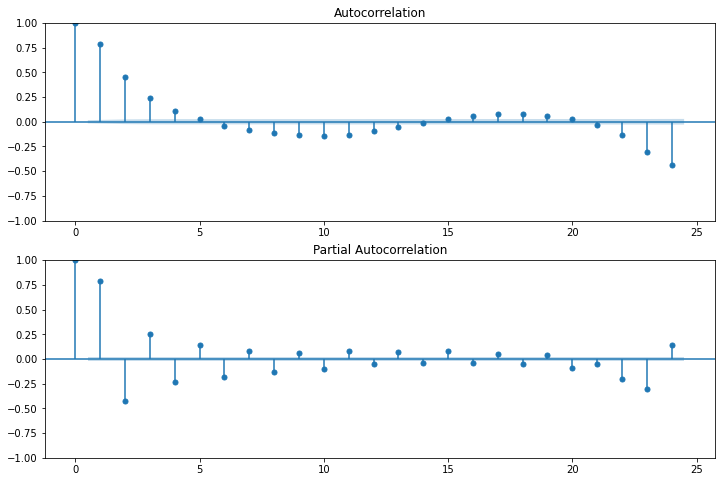

In [24]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_d2, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_d2, lags=24, ax=ax2)

As an aside and for interest, also plot the first-difference of trend, to see the correlations evident in the first-differenced data:

C:\Users\uqachap1\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


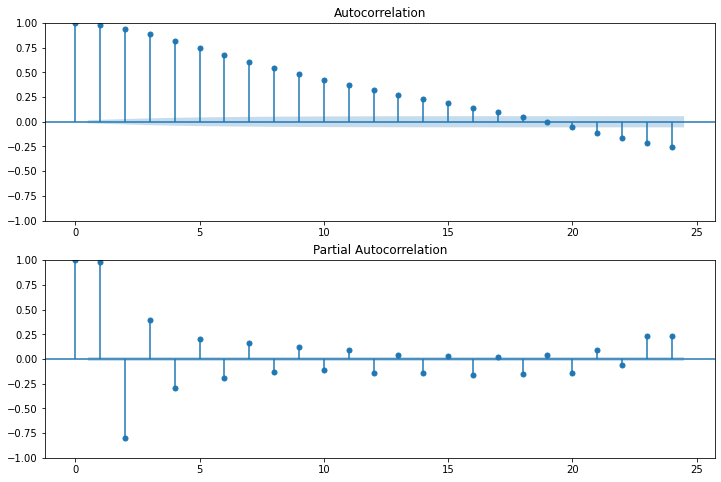

In [25]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_d1[25:], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_d1[25:], lags=24, ax=ax2)

Note that the ACF plot above has a tell-tale sign of non-stationarity, which is a very slowly declining ACF function. If you ever see this, consider differencing your data again. 

### 2.2.2 Fit your first ARIMA model

Now that the data has been made stationary, it can be modelled with an ARMA process. However, when using the software, it is best to use the full ARIMA model and set d=2 as determined above. This is a simple call to the ARIMA method in StatsModels, starting with p =1 and q=0.

In [26]:
arima_1_2_0 = ARIMA(df_temp['MA-24'], order=(1, 2, 0)).fit()
print(arima_1_2_0.summary())

                               SARIMAX Results                                
Dep. Variable:                  MA-24   No. Observations:                15121
Model:                 ARIMA(1, 2, 0)   Log Likelihood               39827.838
Date:                Mon, 17 Oct 2022   AIC                         -79651.676
Time:                        17:46:37   BIC                         -79636.428
Sample:                    01-09-2019   HQIC                        -79646.619
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7848      0.002    401.420      0.000       0.781       0.789
sigma2         0.0003   1.14e-06    261.385      0.000       0.000       0.000
Ljung-Box (L1) (Q):                1716.63   Jarque-

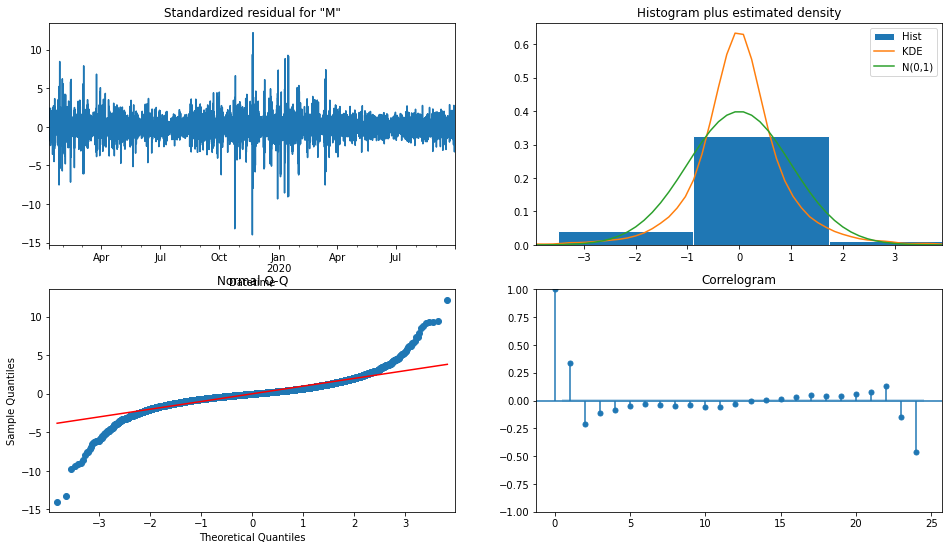

In [27]:
fig = plt.figure(figsize=(16, 9))
fig = arima_1_2_0.plot_diagnostics(fig=fig, lags=24)

## 2.3 Fit higher-order models
Increase the AR lag parameter and re-fit:

In [28]:
arima_2_2_0 = ARIMA(df_temp['MA-24'], order=(2, 2, 0)).fit()
print(arima_1_2_0.summary())

                               SARIMAX Results                                
Dep. Variable:                  MA-24   No. Observations:                15121
Model:                 ARIMA(1, 2, 0)   Log Likelihood               39827.838
Date:                Mon, 17 Oct 2022   AIC                         -79651.676
Time:                        17:46:44   BIC                         -79636.428
Sample:                    01-09-2019   HQIC                        -79646.619
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7848      0.002    401.420      0.000       0.781       0.789
sigma2         0.0003   1.14e-06    261.385      0.000       0.000       0.000
Ljung-Box (L1) (Q):                1716.63   Jarque-

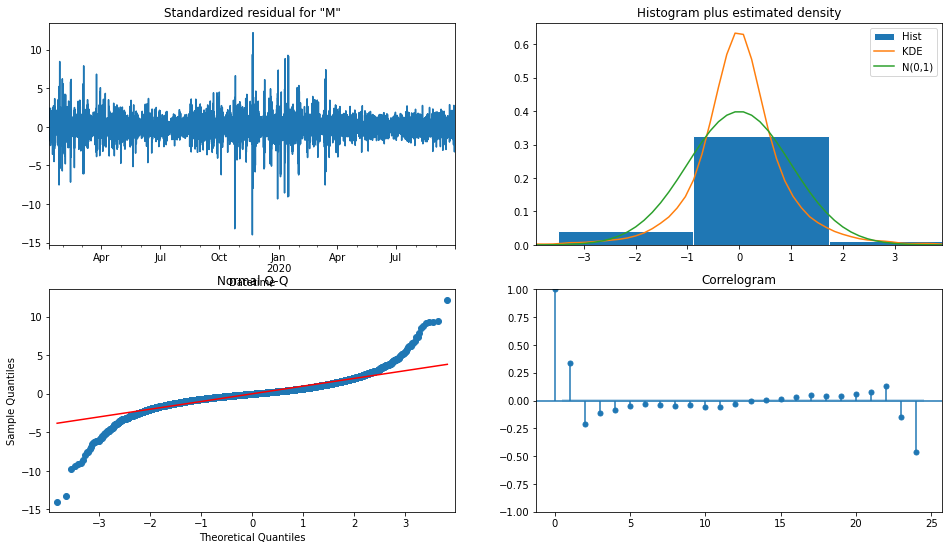

In [29]:
fig = plt.figure(figsize=(16, 9))
fig = arima_1_2_0.plot_diagnostics(fig=fig, lags=24)

## 2.4 Compare the goodness of fit, then continue

Looking at the summary outputs, the AIC for ARIMA(1,2,0) is -79651, while for ARIMA(2,2,0) it is -82728. A similar change is observed in the BIC. Lower AIC and BIC scores are preferred, so this is encouragement to look for further improvements.

At the next iteration, you can try increasing the MA term to q=1:

In [30]:
arima_2_2_1 = ARIMA(df_temp['MA-24'], order=(2, 2, 1)).fit()
print(arima_2_2_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  MA-24   No. Observations:                15121
Model:                 ARIMA(2, 2, 1)   Log Likelihood               42627.339
Date:                Mon, 17 Oct 2022   AIC                         -85246.678
Time:                        17:46:51   BIC                         -85216.183
Sample:                    01-09-2019   HQIC                        -85236.564
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7382      0.006    114.149      0.000       0.725       0.751
ar.L2         -0.1690      0.007    -22.688      0.000      -0.184      -0.154
ma.L1          0.6520      0.006    101.833      0.0

The AIC has continued to drop, now with a score of -85246 for the ARIMA(2,2,1) model, down from -82728 for ARIMA(2,2,0).

You can continue with the iterations increasing p and q, but this is enough to demonstrate the technique for this practical.

# 3. Forecasting with ARIMA

The get_forecast(steps) method is ussed to generate forecast information in a neatly wrapped object. 

See more at https://www.statsmodels.org/v0.11.0/generated/statsmodels.tsa.arima.model.ARIMAResults.get_forecast.html?highlight=get_forecast#statsmodels.tsa.arima.model.ARIMAResults.get_forecast

Keep the predictions orgainsied in a dedicated dataframe, beginning with the mean trend prediction:

In [31]:
arima_fcst = arima_2_2_1.get_forecast(steps=24)
arima_predictions = pd.DataFrame(arima_fcst.predicted_mean)
arima_predictions.rename(columns={"predicted_mean": "trend"}, inplace=True)

## 3.1 Mean trend prediction

Plot the mean prediction

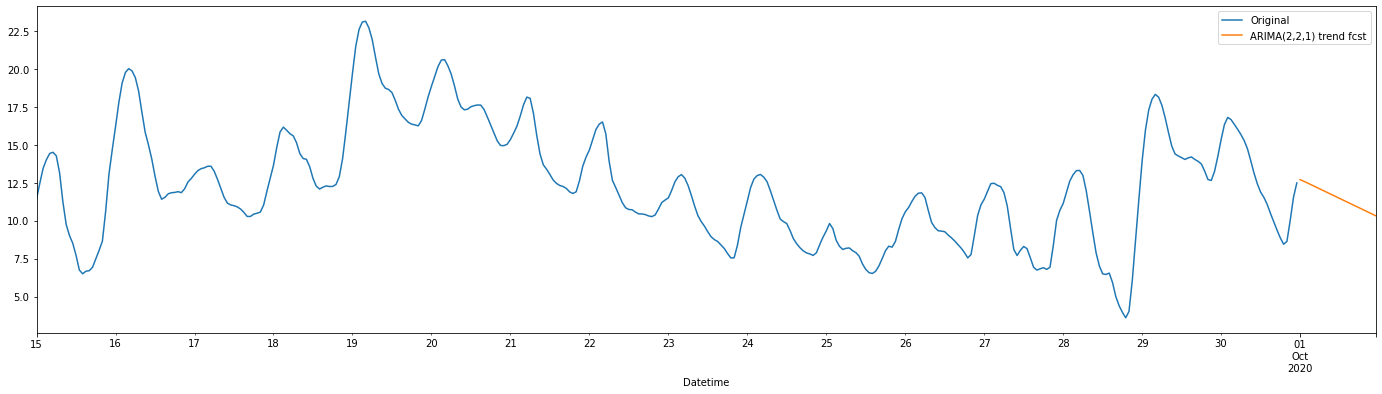

In [32]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
df_temp["2020-09-15":"2020-09-30"]['temperature'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend'].plot(label="ARIMA(2,2,1) trend fcst", ax=ax_arima_fcst)
plt.legend()

# Another way of doing this uses a clunkier interface invoking the predict() method
# f_start="2020-10-01"
# f_end="2020-10-02"
# arima_fcst = arima_2_2_1.predict(start=f_start, end=f_end)
# arima_fcst.index = arima_fcst.index.astype('datetime64[ns]')
# fig, ax_arima_fcst = plt.subplots()
# df_temp["2020-09-15":"2020-09-30"]['temperature'].plot(label='Original', ax=ax_arima_fcst)
# arima_fcst[f_start:f_end].plot(label="ARIMA(2,2,1) trend fcst", ax=ax_arima_fcst)

## 3.2 Adding seasonality back into forecasts

In [33]:
arima_predictions['seasonal'] = hourly_means.tolist()
arima_predictions.head()

,trend,seasonal
2020-10-01 00:00:00,12.708963,1.611022
2020-10-01 01:00:00,12.612471,2.397612
2020-10-01 02:00:00,12.511047,3.239825
2020-10-01 03:00:00,12.407645,3.658603
2020-10-01 04:00:00,12.303615,3.708952


In [34]:
arima_predictions['trend+seasonal'] = arima_predictions['trend'] + arima_predictions['seasonal']
arima_predictions.head()

,trend,seasonal,trend+seasonal
2020-10-01 00:00:00,12.708963,1.611022,14.319985
2020-10-01 01:00:00,12.612471,2.397612,15.010083
2020-10-01 02:00:00,12.511047,3.239825,15.750873
2020-10-01 03:00:00,12.407645,3.658603,16.066248
2020-10-01 04:00:00,12.303615,3.708952,16.012567


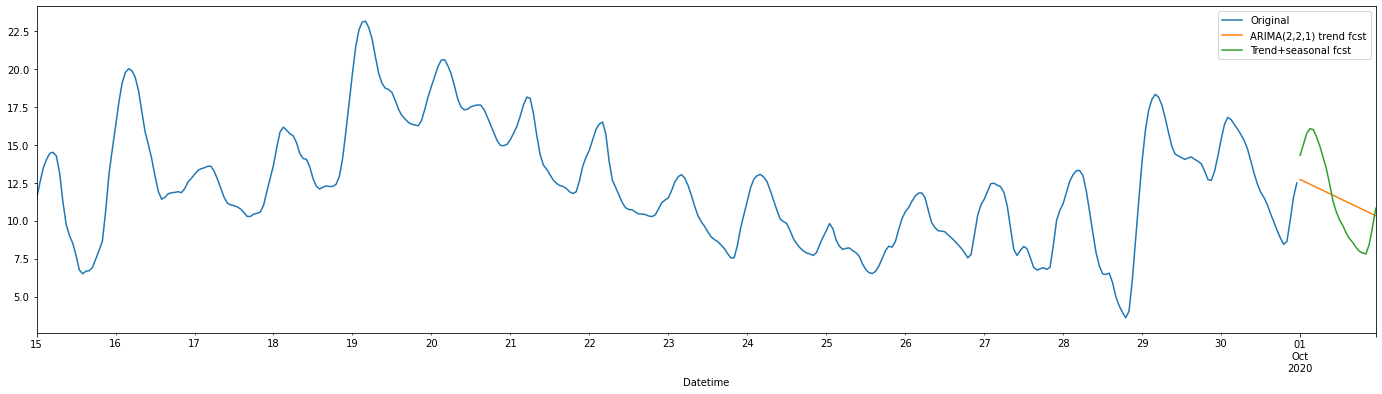

In [35]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
df_temp["2020-09-15":"2020-09-30"]['temperature'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend'].plot(label="ARIMA(2,2,1) trend fcst", ax=ax_arima_fcst)
arima_predictions['trend+seasonal'].plot(label="Trend+seasonal fcst", ax=ax_arima_fcst)
plt.legend()

Plotting a confidence interval for the trend, based on the ARIMA model is easy using the built-in plot_predict() method

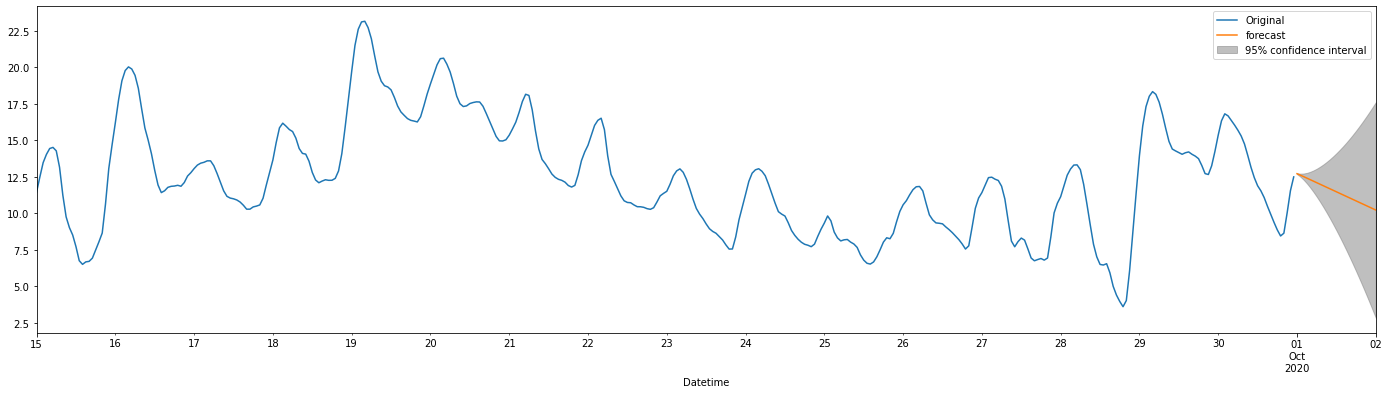

In [36]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
df_temp["2020-09-15":"2020-09-30"]['temperature'].plot(label='Original', ax=ax_arima_fcst)
fig = plot_predict(arima_2_2_1, start="2020-10-01", end="2020-10-02", label='ARIMA(2,2,1) Forecast', ax=ax_arima_fcst)

To do the same for the trend+seasonal series, we have to first access the confidence intervals

In [39]:
arima_fcst.conf_int().head()

,lower MA-24,upper MA-24
2020-10-01 00:00:00,12.680911,12.737015
2020-10-01 01:00:00,12.513320,12.711622
2020-10-01 02:00:00,12.300102,12.721993
2020-10-01 03:00:00,12.050302,12.764987
2020-10-01 04:00:00,11.771072,12.836158


In [40]:
arima_predictions = pd.concat([arima_predictions,arima_fcst.conf_int()], axis = 1)
arima_predictions.rename(columns={"lower MA-24": "trend lower CI", "upper MA-24": "trend upper CI"}, inplace=True)
arima_predictions["seasonal lower CI"] = arima_predictions["trend lower CI"] + arima_predictions['seasonal']
arima_predictions["seasonal upper CI"] = arima_predictions["trend upper CI"] + arima_predictions['seasonal']
arima_predictions.head()

,trend,seasonal,trend+seasonal,trend lower CI,trend upper CI,seasonal lower CI,seasonal upper CI
2020-10-01 00:00:00,12.708963,1.611022,14.319985,12.680911,12.737015,14.291933,14.348037
2020-10-01 01:00:00,12.612471,2.397612,15.010083,12.513320,12.711622,14.910932,15.109234
2020-10-01 02:00:00,12.511047,3.239825,15.750873,12.300102,12.721993,15.539927,15.961818
2020-10-01 03:00:00,12.407645,3.658603,16.066248,12.050302,12.764987,15.708905,16.423590
2020-10-01 04:00:00,12.303615,3.708952,16.012567,11.771072,12.836158,15.480024,16.545110


Using plt.fill_between(), we can emulate the shaded confidence interval plot:

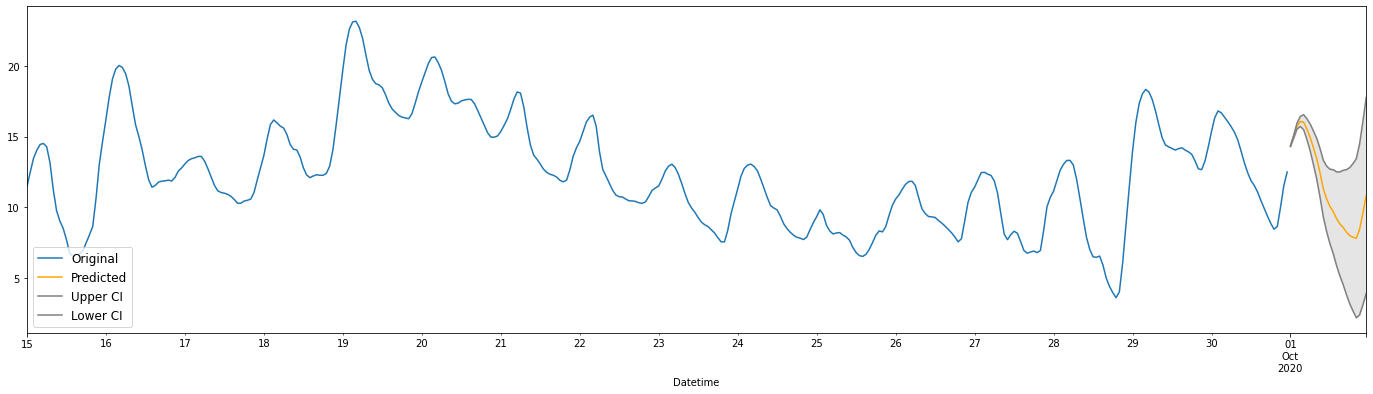

In [42]:
x = arima_predictions.index.values
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
df_temp["2020-09-15":"2020-09-30"]['temperature'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend+seasonal'].plot(color = 'orange',label = 'Predicted' )
arima_predictions['seasonal upper CI'].plot(color = 'grey', label = 'Upper CI')
arima_predictions['seasonal lower CI'].plot(color = 'grey', label = 'Lower CI')

# plot the legend for the first plot
plt.legend(loc = 'lower left', fontsize = 12)

# fill between the conf intervals
plt.fill_between(x, arima_predictions['seasonal lower CI'], arima_predictions['seasonal upper CI'], color='grey', alpha=0.2)